D:\Anaconda\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


Mean Absolute Error in koff: 0.28309 per second.
R2-score test-set: 0.821
R2-score train-set: 0.944
RMSE test-set: 0.378
RMSE train-set: 0.258
MAE test-set: 0.283
MAE train-set: 0.188
MSE test-set: 0.143
No calibration with n_samples <= 20:  consider using more n_estimators in your model,  for more accurate ci and to avoid negative values.


D:\Anaconda\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt
D:\Anaconda\envs\my-rdkit-env\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
D:\Anaconda\envs\my-rdkit-env\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


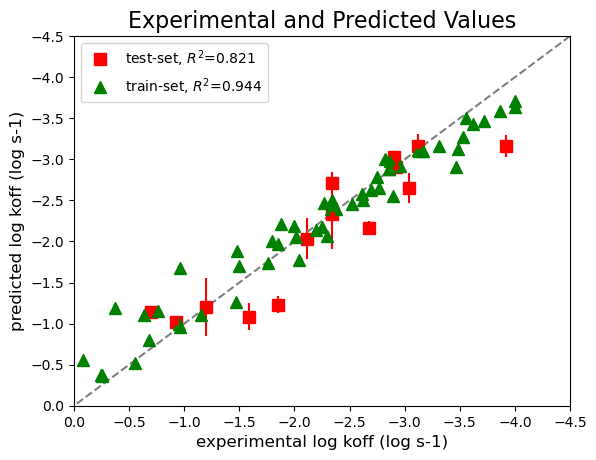

KeyboardInterrupt: 

In [2]:
import pandas as pd
from pandas import *
from numpy import *
import numpy as np
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.optimize import curve_fit
from sklearn.linear_model import *
from sklearn.feature_selection import RFE
from sklearn.model_selection import *
from sklearn.tree import *
from sklearn.metrics import *
import forestci as fci

#loading features from csv-file
features = pd.read_csv('Data-set_Hsp90_17.01.23.csv', ';', usecols=['koff','MWT','TPSA','logP','rotatable bonds','molar refractivity','non-cyclic nitrogen','acyclic single valent nodes', 'cyclic trivalent nodes','acyclic trivalent nodes','mass eigen value high','mass eigen value low','gasteiger charge eigenvalue high','gasteiger charge low','crippen lowgp eigenvalue high','crippen lowgp low','crippen mr eigenvalue high','crippen mr low','valence electrons'])
features.head(72)
features = pd.get_dummies(features, prefix_sep='_', dtype=float)#for the smiles code -> dass sie zahlen sind(0/1)
labels = np.array(features['koff'])#labels value we want to predict
features= features.drop('koff', axis = 1)#remove the label, axis=1 is the column
feature_list = list(features.columns) #saving for later
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 7)

#Building the RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators =200,max_depth = 30,max_features = 'log2', random_state = 7)
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)

#calculate diffrent metrics for comparing the ML-model
print('Mean Absolute Error in koff:', round(np.mean(errors), 5), 'per second.')
predicted = rf.predict(train_features)
expected = train_labels

numerator = ((test_labels - predictions) ** 2).sum()
denominator = ((test_labels - np.average(test_labels)) ** 2).sum()
r2_score1 = 1 - (numerator / denominator)
print('R2-score test-set:',round(r2_score1,3))

numerator = ((expected - predicted) ** 2).sum()
denominator = ((expected - np.average(expected)) ** 2).sum()
r2_score2 = 1 - (numerator / denominator)
print('R2-score train-set:',round(r2_score2,3))
   
MSE = np.square(np.subtract(test_labels,predictions)).mean()
RMSE = math.sqrt(MSE)
print("RMSE test-set:", round(RMSE,3))

MSEt = np.square(np.subtract(expected,predicted)).mean() 
RMSEt = math.sqrt(MSEt)
print("RMSE train-set:", round(RMSEt,3))

 
from sklearn.metrics import *
MAE = mean_absolute_error(test_labels, predictions)
print('MAE test-set:',round(MAE,3))


MAE = mean_absolute_error(expected, predicted)
print('MAE train-set:',round(MAE,3))

MSE = mean_squared_error(test_labels,predictions)
print('MSE test-set:', round(MSE,3))

#plot the predicted and exprected datapoints with errorbars
predictions_data = pd.DataFrame(data = {'koff': test_labels, 'prediction': predictions})
x = test_labels
y = predictions_data['prediction']
mpg_V_IJ_unbiased = fci.random_forest_error(rf, train_features, test_features)
plt.errorbar(x, y, yerr=np.sqrt(mpg_V_IJ_unbiased), fmt = '.r')
plt.plot([-4.5, 0.0], [-4.5, 0], linestyle = '--', color = 'grey')
plt.plot(x,y,'s',markersize = 9, label='test-set, $R^2$=0.821', color = 'red')
plt.plot(expected, predicted, '^',markersize = 9, label='train-set, $R^2$=0.944', color ='green')
plt.xlim(0,-4.5)
plt.ylim(0,-4.5)
plt.xlabel('experimental log koff (log s-1)', fontsize = 12)
plt.ylabel('predicted log koff (log s-1)', fontsize = 12)
plt.legend(loc = 'upper left', fontsize= 10)
plt.title('Experimental and Predicted Values', fontsize = 16)
plt.show()


#calculating the feature importance with permutatation
#from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
r = permutation_importance(rf, train_features, train_labels, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"   {feature_list[i]:35}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

#sort the features with the standard deviation after the importance 
a = list(feature_list)
b = list(r.importances_mean)
c = list(r.importances_std)
my_dict={}
for i in range(len(a)):
    my_dict[a[i]]= (b[i],c[i])

sorted_dictonary=sorted(my_dict.items(), key=lambda x: x[1])
sorted_keys=[k for k, v in sorted_dictonary]
sorted_errors=[v[1] for k, v in sorted_dictonary]
sorted_importance=[v[0] for k, v in sorted_dictonary]

#plot the calculated importance of the features
plt.style.use('ggplot')
x_values = list(range(len(a)))
plt.bar(sorted_keys, sorted_importance, orientation = 'vertical', color = 'darkblue', facecolor=None, yerr=sorted_errors)
plt.xticks(x_values, rotation='vertical', fontsize=10)
plt.yticks(fontsize=11)
plt.ylabel('Importance', fontsize=12); plt.xlabel('Feature', fontsize=12); plt.title('Feature importances measured with permutation')
plt.show() 